# Brief Introduction to Pairs Trading
The goal of any trading stratergy is to maximise profits while minimising risks. Pairs trading is the simplest form of statistical arbitrage, summarised in one sentence: 'Buy (Long) asset that is undervalued and sell (Short) asset that is overvalued'. The underlying assumtion is that the pairs of stock traded in the stratergy, have shown 'similarities in their behaviours' which will almost always converge in the long run, even if they diverge in the short-term. 

Identifying 'correlated' stocks thorugh data processing/ cleansing and hypothesis testing is prioritised over anything else in Pairs Trading. Failiure to do so would yield spurcious relationship between stock pairs, arriving at a non-profitable stratergy. 

# Methodology
The dataset used in this investigation is sourced from Yahoo Finance using the yfinance Python package, which interacts with Yahoo's API to retrieve historical and real time stock data. We shall only focus on stocks that are included in the FTSE 100, 250 and 350 index, as it encompasses the 350 largest companies listed on the London Stock Exchange. 
There are several advantages to the choice: 
1. ** Sufficient Liquidity:** These stocks have higher trading volumes than small cap stocks, which means that the bid-ask spread and latency of execution could be minimised.
2. ** Avioding 'Small Cap Trap':** Trading small cap stocks, even at the small volume could potentially result in unpredictable effects on their prices, rendering the whole stratergy useless

# Importing Data
The dataset concerned in this investigation are stocks selected in FTSE 100, FTSE 250, FTSE 350, which represents about 90% of the total market shares of the UK equity market. Data are obtianed via Yahoo Finance through the use of the Yfinance Python Package. 
1. **Training Data Set:** Data from 2010/01/01 to 2015/12/31 is used for clustering and training the trading model
2. **Back-testing Data set:** Data from 2016/01/01 to 2023/12/31 is used to backtest the model

Please note that while it is possible to implement the concurrent.futures package to run multiple downloads in parallel, it is not done so in my code as Yahoo Finance's Public API (without authentication) limits user to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day), which the concurrent package is shown to exceed, leading to a temporary ban from access.

In [33]:
#Import all required packages

import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import blpapi
from xbbg import blp  # For high-level data access


OSError: dlopen(libblpapi3_64.so, 0x0006): Symbol not found: __ZNSt3__13pmr15memory_resourceD2Ev
  Referenced from: <4514992C-DBEA-3C39-A55A-817F941259DB> /Users/perryhui/miniconda3/lib/libblpapi3_64.so (built for macOS 14.0 which is newer than running OS)
  Expected in:     <AE8EA4B2-B8FD-33E3-A0AF-0B7485AB97C0> /usr/lib/libc++.1.dylib

In [ ]:


ftse100_tickers = ["ADM", "AAF", "ALW", "AAL", "ANTO", "AHT", "ABF", "AZN", "AUTO", "AV", 
    "BA", "BARC", "BTRW", "BEZ", "BKG", "BP", "BATS", "BLND", "BT-A", "BNZL",
     "CNA", "CCH", "CPG", "CTEC", "CRDA", "DCC", "DGE", "DPLM", "EDV", "ENT", 
    "EZJ", "EXPN", "FCIT", "FRES", "GAW", "GLEN", "GSK", "HLN", "HLMA", "HL",
    "HIK", "HSX", "HWDN", "HSBA", "IHG", "IMI", "IMB", "INF", "ICG", "IAG", 
    "ITRK", "JD", "KGF", "LAND", "LGEN", "LLOY", "LMP", "LSEG", "MNG", "MKS", 
    "MRO", "MNDI", "NG", "NWG", "NXT", "PSON", "PSH", "PSN", "PHNX", "PRU", 
    "RKT", "REL", "RTO", "RMV", "RIO", "RR", "SGE", "SBRY", "SDR", "SMT", 
    "SGRO", "SVT", "SHEL", "SMDS", "SMIN", "SN", "SPX", "SSE", "STAN", 
    "STJ", "TW", "TSCO", "ULVR", "UU", "UTG", "VOD", "WEIR", "WTB", "WPP"
]  

ftse250_tickers = [
    "3IN", "FOUR", "ABDN", "ALFA", "ATT", "ALPH", "AO", "APAX", "ASHM", "DGN",
    "AGR", "AML", "ATG", "AGT", "BME", "BAB", "BGFD", "USA", "BAKK", "BBY", 
    "BCG", "BNKR", "BGEO", "BAG", "BBGI", "AJB", "BBH", "BWY", "BHMG", "BYG", 
    "BRGE", "BRSC", "THRG", "BRWM", "BMY", "BSIF", "BOY", "BREE", "BPT", "BVIC", 
    "BUT", "BRBY", "BYIT", "CCR", "CLDN", "CGT", "CCL", "CHG", "CHRY", "CTY", 
    "CKN", "CMCX", "COA", "CCC", "CWK", "CRST", "CURY", "ROO", "DLN", "DLG", 
    "DSCV", "DEC", "DOM", "DWL", "DRX", "DOCS", "DNLM", "EDIN", "EWI", "ELM", 
    "ESP", "ENOG", "ESNT", "EOT", "ESCT", "FXPO", "FCSS", "FEML", "FEV", "FSV", 
    "FGT", "FGP", "FSG", "FSFL", "FRAS", "FUTR", "GCP", "GEN", "GNS", "GSCT", 
    "GDWN", "GFTU", "GRI", "GPE", "UKW", "GNC", "GRG", "HMSO", "HBR", "HVPE", 
    "HWG", "HAS", "HTWS", "HET", "HSL", "HRI", "HGT", "HICL", "HILS", "HFG", 
    "HOC", "BOWL", "HTG", "IBST", "ICGT", "IGG", "IEM", "INCH", "IHP", "IDS", 
    "INPP", "INVP", "IPO", "ITH", "ITV", "IWG", "JLEN", "JMAT", "JAM", "JMG", 
    "JEDT", "JGGI", "JII", "JFJ", "JTC", "JUP", "JUST", "KNOS", "KLR", "KIE", 
    "LRE", "LWDB", "EMG", "MSLH", "MEGP", "MRC", "MRCH", "MTRO", "MAB", "MTO", 
    "MCG", "GROW", "MONY", "MNKS", "MOON", "MGAM", "MGNS", "MUT", "MYI", "NBPE", 
    "NCC", "NESF", "N91", "NAS", "OCDO", "OSB", "OXIG", "ONT", "PHI", "PAGE", 
    "PIN", "PAG", "PPET", "PAY", "PNN", "PNL", "PHLL", "PETS", "PTEC", "PLUS",
    "PCFT", "PCT", "PPH", "PFD", "PHP", "PRS", "QQ", "QLT", "RPI", "RAT", 
    "RWI", "RSW", "RHIM", "RCP", "ROR", "RS1", "RICA", "SAFE", "SVS", "SDP", 
    "SOI", "SAIN", "SEIT", "SNR", "SEQI", "SRP", "SHC", "SRE", "SSON", "SCT", 
    "SXS", "SPI", "SPT", "SSPG", "STEM", "SUPR", "SYNC", "THRL", "TATE", "TBCG",
    "TEP", "TMPL", "TEM", "TRIG", "TIFS", "TCAP", "TRN", "TPK", "BBOX", "TRY", 
    "TRST", "TFIF", "SHED", "VSVS", "VCT", "VEIL", "VOF", "VTY", "FAN", "WPS", 
    "WOSG", "JDW", "SMWH", "WIZZ", "WG", "WKP", "WWH", "XPS", "ZIG"
]

ftse350_tickers = [
    'STEM', 'KNOS', 'BWY', 'ALPH', 'HOC', 'JD', 'FSG', 'BPT', 'FXPO', 'VTY', 
    'EWI', 'DWL', 'ONT', 'OCDO', 'HVPE', 'ROO', 'HBR', 'ELM', 'JTC', 'JUP', 'IPO',
    'TPK', 'DRX', 'NCC', 'EDV', 'SYNC', 'QLT', 'SXS', 'PSH', 'STJ', 'SDR', 'AML',
    'VSVS', 'RTO', 'APAX', 'ESNT', 'MRC', 'OXIG', 'MNDI', 'MSLH', 'BSIF', 'ENOG',
    'PLUS', 'MRO', 'SGRO', 'PNN', 'JUST', 'GCP', 'SAIN', 'BRBY', 'FAN', 'OSB', 'ABDN',
    'BME', 'CKN', 'PHNX', 'SSPG', 'PSN', 'ZIG', 'IWG', 'RS1', 'GEN', 'CRST', 'KLR',
    'TMPL', 'CWK', 'NAS', 'SMT', 'AGT', 'ASHM', 'RSW', 'INCH', 'BP', 'BBOX', 'VOD',
    'BOY', 'ITRK', 'BYIT', 'HFG', 'MGNS', 'EOT', 'THRG', 'HMSO', 'VOF', 'SSON', 'AGR',
    'MOON', 'PHP', 'BTRW', 'FEML', 'SHEL', 'WG', 'BAKK', 'GRG', 'RWI', 'SVS', 'BREE',
    'LWDB', 'GRI', 'MCG', 'ESP', 'VEIL', 'EMG', 'GFTU', 'HGT', 'KGF', 'SEIT', 'TEP',
    'BLND', 'COA', 'ITH', 'BARC', 'DSCV', 'ICG', 'USA', 'DNLM', 'TRN', 'FUTR', 'AAL',
    'WIZZ', 'HICL', 'DOCS', 'LGEN', 'BOWL', 'FSFL', 'MTRO', 'GNS', 'PAY', 'JII', 'TW',
    'BRWM', 'DOM', 'FEV', 'RIO', 'GAW', 'BBGI', 'HSL', 'MNKS', 'SPI', 'MUT', 'GROW',
    'UKW', 'PPET', 'KIE', 'PAG', 'EDIN', 'HWDN', 'PPH', 'MNG', 'INF', 'GPE', 'MAB',
    'BUT', 'ITV', 'INVP', 'PHLL', 'RCP', 'INPP', 'MYI', 'BBY', 'FGEN', 'RAT', 'HILS',
    'N91', 'PFD', 'FSV', 'SPX', 'BYG', 'VCT', 'GSK', 'SN', 'DGE', 'CHRY', 'SMWH', 'BKG',
    'CRDA', 'LRE', 'ADM', 'MRCH', 'ENT', 'FCSS', 'WPP', 'BMY', 'JAM', 'FRES', 'BRSC',
    'HLN', 'CCC', 'BBH', 'PCFT', 'SRE', 'CNA', 'TRIG', 'CTEC', 'CTY', 'HAS', 'ALW',
    'TRY', 'IBST', 'DLG', 'SEQI', 'JMAT', 'HSX', 'JMG', 'MGAM', 'BRGE', 'TSCO', 'DGN',
    'AV', 'ROR', 'PTEC', 'PHI', 'REL', 'CURY', 'AHT', 'NG', 'DEC', 'LMP', 'DPLM', 'LLOY',
    'IEM', 'PAGE', 'RPI', 'NESF', 'LAND', 'ATT', 'PRU', 'SCT', 'SHED', 'SMIN', 'AUTO',
    'CCL', 'FRAS', 'AZN', 'CLDN', 'UU', 'AJB', 'ASL', 'RKT', 'WOSG', 'CGT', 'EXPN',
    'NWG', 'SBRY', 'PETS', 'BT.A', 'HSBA', 'HIK', 'PCT', 'HRI', 'PNL', 'STAN', 'UTG',
    'TFIF', 'GSCT', 'BEZ', 'MONY', 'MTO', 'ATG', 'JFJ', 'ESCT', 'BNKR', 'ABF', 'CPG',
    'JEDT', 'IDS', 'TBCG', 'BGEO', 'GLEN', 'PIN', 'RHIM', 'BA', 'IGG', 'XPS', 'ULVR',
    'NBPE', 'QQ', 'SVT', 'ALFA', 'WKP', 'CMCX', 'SRP', 'TCAP', 'SDP', 'BAB', 'BATS',
    'JDW', 'BAG', 'THRL', 'HTWS',
]


# define a class for data retrival
class Stock_Processor:
    def __init__(self, Output_path = '/Users/perryhui/Desktop/Pairs_Trading'):
        self.data = {}
        self.data_combined = None
        self.output_path = Output_path
        self.file_name = None
    # Define a funtion to download close price
    def Download_Data(self, tickers, tickers_name, start_date="2010-01-01", end_date="2023-12-31", interval = '1d'):
        for ticker in tickers:
            try: 
                temp_data = yf.download(ticker, start=start_date, end=end_date, interval=interval)[['Close']]
                if not temp_data.empty: 
                    print(f'Sucessfully downloaded data for {ticker}')
                else:
                    print(f'Unable to Download data for {ticker}')
                self.data[ticker] = temp_data
            except Exception as e:
                print(f"Error downloading data for {ticker}: {e}")
        if self.data:
            self.data_combined = pd.concat(self.data.values(), axis=1, keys=self.data.keys())
            self.data_combined = self.data_combined.iloc[2:].reset_index(drop=True)
            self.file_name = f'{tickers_name}_daily.csv'
            self.data_combined.to_csv(os.path.join(self.output_path, self.file_name))
        else:
            print("No data to save.")
    # Define a funtion to download hourly close price
processor = Stock_Processor()

#Download Daily Data
ftse100_daily  = processor.Download_Data(ftse100_tickers, 'ftse100')
ftse250_daily = processor.Download_Data(ftse250_tickers, 'ftse250')
ftse350_daily = processor.Download_Data(ftse350_tickers, 'ftse350')

#Download Hourly Data
ftse100_hourly = processor.Download_Data(ftse100_tickers, 'ftse100', interval='1h')
ftse250_hourly = processor.Download_Data(ftse250_tickers, 'ftse250', interval='1h')
ftse350_hourly = processor.Download_Data(ftse350_tickers, 'ftse350', interval='1h')
        


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ADM
Sucessfully downloaded data for AAF
Sucessfully downloaded data for ALW


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for AAL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANTO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ANTO
Sucessfully downloaded data for AHT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ABF
Sucessfully downloaded data for AZN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AUTO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for AUTO
Unable to Download data for AV


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BARC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BARC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTRW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BTRW
Sucessfully downloaded data for BEZ
Sucessfully downloaded data for BKG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BATS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BP
Unable to Download data for BATS
Sucessfully downloaded data for BLND


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BT-A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BT-A


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BNZL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BNZL
Sucessfully downloaded data for CNA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for CCH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CPG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRDA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for CPG
Sucessfully downloaded data for CTEC
Unable to Download data for CRDA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for DCC
Sucessfully downloaded data for DGE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DPLM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for DPLM
Sucessfully downloaded data for EDV


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ENT
Sucessfully downloaded data for EZJ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EXPN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for EXPN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCIT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for FCIT
Sucessfully downloaded data for FRES
Sucessfully downloaded data for GAW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for GLEN
Sucessfully downloaded data for GSK


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for HLN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HLMA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for HLMA
Sucessfully downloaded data for HL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for HIK
Sucessfully downloaded data for HSX


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HWDN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HWDN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HSBA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HSBA


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for IHG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IMI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for IMI
Sucessfully downloaded data for IMB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Unable to Download data for INF
Sucessfully downloaded data for ICG
Sucessfully downloaded data for IAG



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ITRK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ITRK
Sucessfully downloaded data for JD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for KGF
Sucessfully downloaded data for LAND


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LGEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for LGEN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLOY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for LLOY
Sucessfully downloaded data for LMP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LSEG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for LSEG
Sucessfully downloaded data for MNG
Sucessfully downloaded data for MKS


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MRO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MNDI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MNDI
Sucessfully downloaded data for NG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for NWG
Sucessfully downloaded data for NXT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PSON']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PSON
Sucessfully downloaded data for PSH
Sucessfully downloaded data for PSN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PHNX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PHNX
Sucessfully downloaded data for PRU


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for RKT
Sucessfully downloaded data for REL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for RTO
Sucessfully downloaded data for RMV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for RIO
Sucessfully downloaded data for RR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SGE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SGE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBRY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SBRY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SDR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SDR
Unable to Download data for SMT
Sucessfully downloaded data for SGRO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SVT
Sucessfully downloaded data for SHEL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMDS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SMDS
Sucessfully downloaded data for SMIN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for SN
Sucessfully downloaded data for SPX
Unable to Download data for SSE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['STJ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for STAN
Unable to Download data for STJ
Sucessfully downloaded data for TW


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for TSCO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ULVR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UU']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for ULVR
Unable to Download data for UU


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for UTG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for VOD
Sucessfully downloaded data for WEIR
Sucessfully downloaded data for WTB


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for WPP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['3IN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for 3IN
Sucessfully downloaded data for FOUR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABDN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ABDN
Sucessfully downloaded data for ALFA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALPH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for ATT
Unable to Download data for ALPH
Unable to Download data for AO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APAX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for APAX


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASHM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ASHM
Sucessfully downloaded data for DGN
Sucessfully downloaded data for AGR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for AML
Sucessfully downloaded data for ATG


[*********************100%***********************]  1 of 1 completed

Sucessfully downloaded data for AGT
Sucessfully downloaded data for BME



[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BAB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BGFD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BGFD
Sucessfully downloaded data for USA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAKK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BAKK
Sucessfully downloaded data for BBY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BCG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1703998800")')


Unable to Download data for BCG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BNKR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BNKR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BGEO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BGEO
Sucessfully downloaded data for BAG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BBGI
Sucessfully downloaded data for AJB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BBH
Sucessfully downloaded data for BWY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BHMG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRGE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for BHMG
Sucessfully downloaded data for BYG
Unable to Download data for BRGE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRSC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BRSC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['THRG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for THRG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRWM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BRWM


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BMY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BSIF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BSIF
Sucessfully downloaded data for BOY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BREE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BREE
Sucessfully downloaded data for BPT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BVIC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BUT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for BVIC
Unable to Download data for BUT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRBY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BYIT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for BRBY
Unable to Download data for BYIT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLDN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for CCR
Unable to Download data for CLDN
Sucessfully downloaded data for CGT


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for CCL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for CHG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHRY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for CHRY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CTY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for CTY
Sucessfully downloaded data for CKN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMCX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for CMCX
Sucessfully downloaded data for COA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRST']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for CCC
Sucessfully downloaded data for CWK
Unable to Download data for CRST


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CURY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for CURY
Sucessfully downloaded data for ROO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for DLN
Sucessfully downloaded data for DLG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DSCV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for DSCV
Sucessfully downloaded data for DEC
Sucessfully downloaded data for DOM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DWL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for DWL
Sucessfully downloaded data for DRX
Sucessfully downloaded data for DOCS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DNLM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EDIN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for DNLM
Unable to Download data for EDIN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for EWI
Sucessfully downloaded data for ELM


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ESP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENOG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ENOG
Sucessfully downloaded data for ESNT


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for EOT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ESCT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ESCT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FXPO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for FXPO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCSS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for FCSS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FEML']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for FEML
Sucessfully downloaded data for FEV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for FSV
Sucessfully downloaded data for FGT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FGP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for FGP
Sucessfully downloaded data for FSG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FSFL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for FSFL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FRAS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for FRAS
Sucessfully downloaded data for FUTR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GCP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for GCP
Sucessfully downloaded data for GEN


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for GNS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GSCT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for GSCT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GDWN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for GDWN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GFTU']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for GFTU
Sucessfully downloaded data for GRI
Sucessfully downloaded data for GPE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UKW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for UKW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GNC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for GNC
Sucessfully downloaded data for GRG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HMSO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HBR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for HMSO
Unable to Download data for HBR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HVPE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HWG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for HVPE
Unable to Download data for HWG


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for HAS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HTWS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for HTWS
Sucessfully downloaded data for HET
Sucessfully downloaded data for HSL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HGT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for HRI
Unable to Download data for HGT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HICL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HICL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HILS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for HILS
Sucessfully downloaded data for HFG
Sucessfully downloaded data for HOC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BOWL
Sucessfully downloaded data for HTG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IBST']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for IBST


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IEM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for ICGT
Sucessfully downloaded data for IGG
Unable to Download data for IEM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IDS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for INCH
Sucessfully downloaded data for IHP
Unable to Download data for IDS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INPP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for INPP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INVP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Unable to Download data for INVP
Sucessfully downloaded data for IPO
Sucessfully downloaded data for ITH



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ITV
Sucessfully downloaded data for IWG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JLEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for JLEN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JMAT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JAM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JMG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for JMAT
Unable to Download data for JAM
Unable to Download data for JMG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JEDT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for JEDT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JGGI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JII']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JFJ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for JGGI
Unable to Download data for JII
Unable to Download data for JFJ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for JTC
Sucessfully downloaded data for JUP
Sucessfully downloaded data for JUST


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for KNOS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KLR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for KLR
Sucessfully downloaded data for KIE


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for LRE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LWDB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for LWDB
Sucessfully downloaded data for EMG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSLH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for MSLH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MEGP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRCH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for MEGP
Sucessfully downloaded data for MRC
Unable to Download data for MRCH


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MTRO
Sucessfully downloaded data for MAB


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MTO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MCG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MCG
Sucessfully downloaded data for GROW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MONY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for MONY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MNKS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MNKS
Sucessfully downloaded data for MOON
Sucessfully downloaded data for MGAM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MGNS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MGNS
Sucessfully downloaded data for MUT


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MYI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NBPE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for NBPE
Sucessfully downloaded data for NCC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NESF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for NESF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['N91']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for N91
Sucessfully downloaded data for NAS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OCDO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for OCDO


Failed to get ticker 'OSB' reason: Response ended prematurely
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OSB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for OSB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXIG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for OXIG
Sucessfully downloaded data for ONT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PHI
Sucessfully downloaded data for PAGE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PIN
Sucessfully downloaded data for PAG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PPET']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PPET
Sucessfully downloaded data for PAY
Sucessfully downloaded data for PNN


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PNL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PHLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PHLL
Sucessfully downloaded data for PETS


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PTEC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PCFT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PLUS
Unable to Download data for PCFT
Sucessfully downloaded data for PCT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PPH
Sucessfully downloaded data for PFD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PHP
Sucessfully downloaded data for PRS
Sucessfully downloaded data for QQ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RPI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for QLT
Unable to Download data for RPI
Sucessfully downloaded data for RAT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for RWI
Sucessfully downloaded data for RSW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RHIM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for RHIM
Sucessfully downloaded data for RCP


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ROR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RS1']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for RS1


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RICA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for RICA
Sucessfully downloaded data for SAFE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SVS
Sucessfully downloaded data for SDP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SOI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SAIN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SAIN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SEIT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SEIT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SNR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SEQI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SEQI
Sucessfully downloaded data for SRP
Sucessfully downloaded data for SHC


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SRE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSON']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SSON
Sucessfully downloaded data for SCT
Sucessfully downloaded data for SXS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SPI
Sucessfully downloaded data for SPT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSPG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SSPG
Sucessfully downloaded data for STEM
Sucessfully downloaded data for SUPR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SYNC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SYNC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['THRL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for THRL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TATE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for TATE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TBCG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TMPL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for TBCG
Sucessfully downloaded data for TEP
Unable to Download data for TMPL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TEM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1703998800")')


Unable to Download data for TEM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TRIG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for TRIG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TIFS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for TIFS
Sucessfully downloaded data for TCAP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for TRN
Sucessfully downloaded data for TPK


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BBOX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for TRY
Sucessfully downloaded data for TRST


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TFIF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for TFIF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHED']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SHED


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VSVS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for VSVS
Sucessfully downloaded data for VCT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VEIL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VOF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for VEIL
Unable to Download data for VOF
Sucessfully downloaded data for VTY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for FAN
Sucessfully downloaded data for WPS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WOSG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for WOSG
Sucessfully downloaded data for JDW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMWH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SMWH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WIZZ']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WWH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for WIZZ
Unable to Download data for WG
Sucessfully downloaded data for WKP
Unable to Download data for WWH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XPS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for XPS
Sucessfully downloaded data for ZIG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for STEM
Sucessfully downloaded data for KNOS
Sucessfully downloaded data for BWY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALPH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Unable to Download data for ALPH
Sucessfully downloaded data for HOC
Sucessfully downloaded data for JD



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for FSG
Sucessfully downloaded data for BPT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FXPO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Unable to Download data for FXPO
Sucessfully downloaded data for VTY



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DWL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for EWI
Unable to Download data for DWL
Sucessfully downloaded data for ONT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OCDO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for OCDO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HVPE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HBR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for HVPE
Sucessfully downloaded data for ROO
Unable to Download data for HBR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ELM
Sucessfully downloaded data for JTC
Sucessfully downloaded data for JUP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Sucessfully downloaded data for IPO
Sucessfully downloaded data for TPK
Sucessfully downloaded data for DRX



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SYNC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Sucessfully downloaded data for NCC
Sucessfully downloaded data for EDV
Unable to Download data for SYNC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['STJ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for QLT
Sucessfully downloaded data for SXS
Sucessfully downloaded data for PSH
Unable to Download data for STJ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SDR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VSVS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SDR
Sucessfully downloaded data for AML
Unable to Download data for VSVS


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for RTO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APAX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for APAX
Sucessfully downloaded data for ESNT


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MRC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXIG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for OXIG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MNDI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for MNDI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSLH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for MSLH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BSIF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BSIF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENOG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ENOG


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PLUS


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MRO


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SGRO


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PNN


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for JUST


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GCP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for GCP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SAIN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SAIN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRBY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BRBY
Sucessfully downloaded data for FAN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OSB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for OSB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABDN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ABDN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BME
Sucessfully downloaded data for CKN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PHNX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for PHNX


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSPG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SSPG
Sucessfully downloaded data for PSN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ZIG
Sucessfully downloaded data for IWG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RS1']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for RS1
Sucessfully downloaded data for GEN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRST']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for CRST


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KLR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TMPL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for KLR
Unable to Download data for TMPL
Sucessfully downloaded data for CWK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for NAS
Unable to Download data for SMT


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for AGT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASHM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Unable to Download data for ASHM
Sucessfully downloaded data for RSW
Sucessfully downloaded data for INCH



[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BP


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BBOX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for VOD
Sucessfully downloaded data for BOY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ITRK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BYIT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for ITRK
Unable to Download data for BYIT
Sucessfully downloaded data for HFG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MGNS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Unable to Download data for MGNS


Sucessfully downloaded data for EOT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['THRG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for THRG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HMSO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VOF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for HMSO
Unable to Download data for VOF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSON']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SSON
Sucessfully downloaded data for AGR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MOON
Sucessfully downloaded data for PHP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTRW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BTRW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FEML']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for FEML


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for SHEL
Unable to Download data for WG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAKK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BAKK
Sucessfully downloaded data for GRG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for RWI
Sucessfully downloaded data for SVS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BREE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BREE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LWDB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for LWDB
Sucessfully downloaded data for GRI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MCG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MCG
Sucessfully downloaded data for ESP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VEIL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for VEIL
Sucessfully downloaded data for EMG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GFTU']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HGT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

Unable to Download data for GFTU
Unable to Download data for HGT


Sucessfully downloaded data for KGF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SEIT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SEIT


[*********************100%***********************]  1 of 1 completed

Sucessfully downloaded data for TEP
Sucessfully downloaded data for BLND



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for COA
Sucessfully downloaded data for ITH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BARC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BARC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DSCV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for DSCV
Sucessfully downloaded data for ICG


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for USA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DNLM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for DNLM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for TRN
Sucessfully downloaded data for FUTR


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for AAL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WIZZ']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for WIZZ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HICL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for HICL
Sucessfully downloaded data for DOCS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LGEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Unable to Download data for LGEN
Sucessfully downloaded data for BOWL



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FSFL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for FSFL
Sucessfully downloaded data for MTRO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JII']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for GNS
Sucessfully downloaded data for PAY
Unable to Download data for JII


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for TW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRWM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BRWM
Sucessfully downloaded data for DOM


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for FEV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Sucessfully downloaded data for RIO
Sucessfully downloaded data for GAW



[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BBGI
Sucessfully downloaded data for HSL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MNKS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MNKS
Sucessfully downloaded data for SPI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MUT
Sucessfully downloaded data for GROW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UKW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PPET']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for UKW
Unable to Download data for PPET


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for KIE
Sucessfully downloaded data for PAG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EDIN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for EDIN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HWDN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Unable to Download data for HWDN
Sucessfully downloaded data for PPH



[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MNG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for INF
Sucessfully downloaded data for GPE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BUT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for MAB
Unable to Download data for BUT
Sucessfully downloaded data for ITV


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INVP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for INVP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PHLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PHLL
Sucessfully downloaded data for RCP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INPP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for INPP
Sucessfully downloaded data for MYI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BBY
Sucessfully downloaded data for FGEN
Sucessfully downloaded data for RAT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HILS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HILS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['N91']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for N91


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for PFD
Sucessfully downloaded data for FSV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SPX
Sucessfully downloaded data for BYG


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for VCT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for GSK
Sucessfully downloaded data for SN
Sucessfully downloaded data for DGE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHRY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for CHRY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMWH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRDA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for SMWH
Sucessfully downloaded data for BKG
Unable to Download data for CRDA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for LRE
Sucessfully downloaded data for ADM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRCH']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for MRCH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ENT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCSS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for FCSS
Sucessfully downloaded data for WPP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JAM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for BMY
Unable to Download data for JAM
Sucessfully downloaded data for FRES


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRSC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for BRSC
Sucessfully downloaded data for HLN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for CCC
Sucessfully downloaded data for BBH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PCFT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PCFT
Sucessfully downloaded data for SRE


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for CNA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TRIG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for TRIG
Sucessfully downloaded data for CTEC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CTY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for CTY
Sucessfully downloaded data for HAS


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ALW


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for TRY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IBST']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for IBST
Sucessfully downloaded data for DLG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SEQI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SEQI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JMAT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JMG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for JMAT
Sucessfully downloaded data for HSX
Unable to Download data for JMG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRGE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for MGAM
Unable to Download data for BRGE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for TSCO
Sucessfully downloaded data for DGN
Unable to Download data for AV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ROR
Sucessfully downloaded data for PTEC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CURY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for PHI
Sucessfully downloaded data for REL
Unable to Download data for CURY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for AHT
Sucessfully downloaded data for NG
Sucessfully downloaded data for DEC


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for LMP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DPLM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for DPLM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLOY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IEM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RPI']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for LLOY
Unable to Download data for IEM
Sucessfully downloaded data for PAGE
Unable to Download data for RPI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NESF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for NESF
Sucessfully downloaded data for LAND


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for ATT
Sucessfully downloaded data for PRU


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SCT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHED']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for SHED
Sucessfully downloaded data for SMIN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AUTO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for AUTO


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for CCL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FRAS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for FRAS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLDN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UU']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for AZN
Unable to Download data for CLDN
Unable to Download data for UU


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for AJB
Sucessfully downloaded data for ASL
Sucessfully downloaded data for RKT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WOSG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for WOSG
Sucessfully downloaded data for CGT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EXPN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for EXPN
Sucessfully downloaded data for NWG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBRY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Unable to Download data for SBRY
Sucessfully downloaded data for PETS



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BT.A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BT.A


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HSBA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for HSBA
Sucessfully downloaded data for HIK
Sucessfully downloaded data for PCT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for HRI
Sucessfully downloaded data for PNL
Sucessfully downloaded data for STAN


[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for UTG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TFIF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for TFIF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GSCT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for GSCT
Sucessfully downloaded data for BEZ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MONY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Unable to Download data for MONY
Sucessfully downloaded data for MTO
Sucessfully downloaded data for ATG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JFJ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for JFJ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ESCT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ESCT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BNKR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for BNKR
Unable to Download data for ABF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CPG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for CPG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JEDT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IDS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for JEDT
Unable to Download data for IDS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TBCG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for TBCG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BGEO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BGEO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for GLEN
Sucessfully downloaded data for PIN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RHIM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for RHIM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IGG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XPS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for BA
Unable to Download data for IGG
Unable to Download data for XPS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ULVR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ULVR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NBPE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for NBPE
Unable to Download data for QQ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WKP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Sucessfully downloaded data for SVT
Sucessfully downloaded data for ALFA
Unable to Download data for WKP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMCX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SRP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TCAP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for CMCX
Unable to Download data for SRP
Unable to Download data for TCAP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sucessfully downloaded data for SDP
Sucessfully downloaded data for BAB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BATS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JDW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2023-12-31)')


Unable to Download data for BATS
Unable to Download data for JDW
Unable to Download data for BAG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['THRL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for THRL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HTWS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HTWS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for ADM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for AAF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for ALW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for AAL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANTO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ANTO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AHT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for AHT
Unable to Download data for ABF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for AZN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AUTO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for AUTO
Unable to Download data for AV


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for BA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BARC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BARC


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTRW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BEZ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for BTRW
Unable to Download data for BEZ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BKG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for BKG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BATS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for BP
Unable to Download data for BATS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BLND']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1626442200 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for BLND


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BT-A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BT-A


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BNZL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for BNZL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CNA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for CNA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CPG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for CCH
Unable to Download data for CPG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CTEC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1603978200 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRDA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for CTEC
Unable to Download data for CRDA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DCC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DGE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for DCC
Unable to Download data for DGE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DPLM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for DPLM


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EDV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for EDV


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ENT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EZJ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for EZJ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EXPN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for EXPN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCIT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for FCIT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FRES']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1580394600 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for FRES


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GAW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1447684200 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for GAW
Unable to Download data for GLEN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GSK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for GSK


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HLN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1658755800 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for HLN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HLMA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HLMA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for HL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HIK']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1274967000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for HIK


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HSX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for HSX


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HWDN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HWDN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HSBA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for HSBA


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IHG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for IHG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IMI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IMB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for IMI
Unable to Download data for IMB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INF']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for INF
Sucessfully downloaded data for ICG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IAG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for IAG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ITRK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for ITRK


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1400765400 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for JD


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KGF']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for KGF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LAND']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1359469800 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for LAND


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LGEN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for LGEN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLOY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for LLOY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LMP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1405344600 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for LMP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LSEG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MNG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for LSEG
Unable to Download data for MNG
Sucessfully downloaded data for MKS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for MRO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MNDI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for MNDI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for NG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NWG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for NWG
Sucessfully downloaded data for NXT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PSON']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for PSON
Sucessfully downloaded data for PSH


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PSN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1557322200 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for PSN


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PHNX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for PHNX


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PRU']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for PRU


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RKT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1596720600 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['REL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for RKT
Unable to Download data for REL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RMV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for RTO
Unable to Download data for RMV


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed


Unable to Download data for RIO
Sucessfully downloaded data for RR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SGE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SGE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBRY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SBRY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SDR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SGRO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for SDR
Unable to Download data for SMT
Unable to Download data for SGRO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SVT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for SVT


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHEL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for SHEL


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMDS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Unable to Download data for SMDS


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMIN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1328797800 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for SMIN
Sucessfully downloaded data for SN
Unable to Download data for SPX


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SSE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['STAN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['STJ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for SSE
Unable to Download data for STAN
Unable to Download data for STJ


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1554384600 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for TW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSCO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for TSCO


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ULVR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UU']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for ULVR
Unable to Download data for UU


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UTG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for UTG


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VOD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WEIR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31)')


Unable to Download data for VOD
Unable to Download data for WEIR


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WTB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for WTB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WPP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2010-01-01 -> 2023-12-31) (Yahoo error = "1h data not available for startTime=1262322000 and endTime=1703998800. The requested range must be within the last 730 days.")')


Unable to Download data for WPP


TypeError: Cannot join tz-naive with tz-aware DatetimeIndex

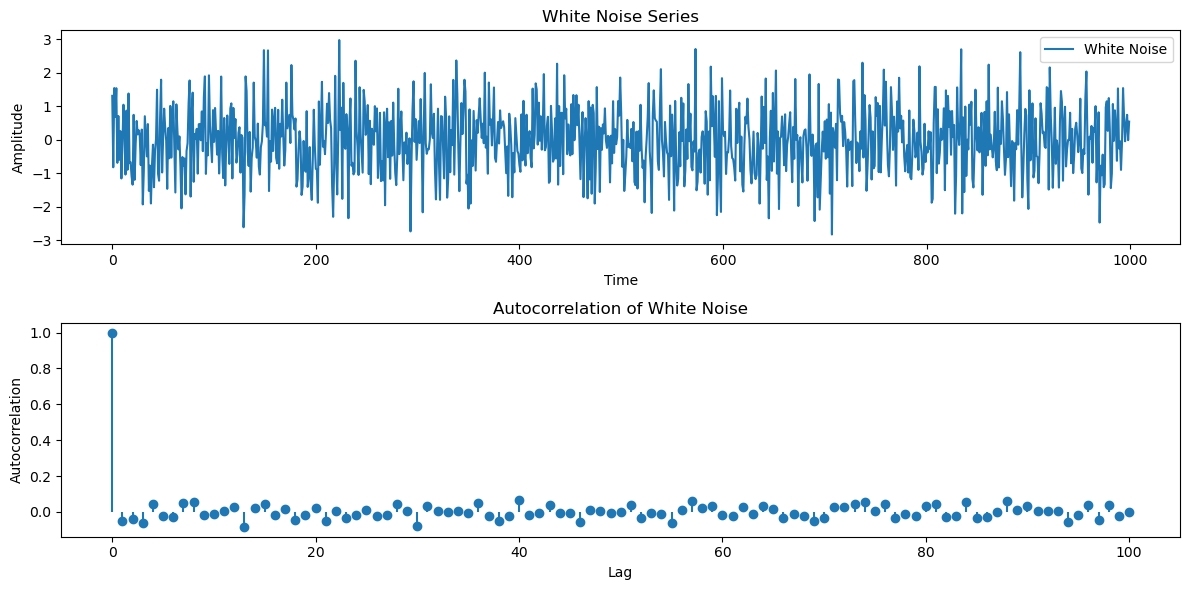

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Parameters
n = 1000  # Number of points in the series
mean = 0  # Mean of the white noise
std_dev = 1  # Standard deviation of the white noise

# Generate white noise
white_noise = np.random.normal(mean, std_dev, n)

# Calculate autocorrelation
lags = 100 # Number of lags to consider
autocorr = acf(white_noise, nlags=lags)

# Plot white noise
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(white_noise, label="White Noise")
plt.title("White Noise Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Plot autocorrelation
plt.subplot(2, 1, 2)
plt.stem(range(lags + 1), autocorr, basefmt=" ")
plt.title("Autocorrelation of White Noise")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()

plt.show()



In [ ]:
n 

In [ ]:
n = 1000
mean = 0
std_dev = 1
white_noise = np.random.normal(mean, std_dev, n)
lags = n

# Data Cleansing
In this step, we shall first discount stocks that are merged, delisted or exchanged in the sample period; stocks with more than half missing data across the training period are also discounted. In practice, stocks with negative prices as well as low trading volume should also be discounted. But since none of the stocks investigated show such chracteristics, we will ignore it for now.  